In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm # For korean characters
import seaborn as sns
import numpy as np
import sqlite3

In [39]:
daily_data = pd.read_csv('daily_improvement.csv')
weekly_data = pd.read_csv('weekly_improvement.csv')
monthly_data = pd.read_csv('monthly_improvement.csv')

In [40]:
daily_data.head()

,id,team,gained_lp,interval_winrate
0,저승민#이승민,KT Rolster [PerfecT],140,60%
1,septem#ber,Suning [huanfeng],117,56%
2,하와와#0904,[DDahyuk],106,71%
3,qazwsx#abc,[Art],95,73%
4,웅냥냥#KR0,OKSavingsBank BRION [HamBak],86,70%


In [41]:
# Match any string between [] brackets; it's the real nickname of the player which is irrelevant to the team name.
daily_data['team'] = daily_data['team'].str.replace(r'\[.*?\]', '', regex=True)
daily_data.head()

,id,team,gained_lp,interval_winrate
0,저승민#이승민,KT Rolster,140,60%
1,septem#ber,Suning,117,56%
2,하와와#0904,,106,71%
3,qazwsx#abc,,95,73%
4,웅냥냥#KR0,OKSavingsBank BRION,86,70%


In [42]:
# Replace empty strings or spaces with NaN, so that we can fill them.
daily_data['team'] = daily_data['team'].replace(r'^\s*$', np.nan, regex=True)

In [43]:
# If the team value is "Retired", this means that this player isn't associated with any team at the moment.
daily_data['team'] = daily_data['team'].fillna("Retired")

In [44]:
daily_data['team'].head(20)

0                   KT Rolster 
1                       Suning 
2                       Retired
3                       Retired
4          OKSavingsBank BRION 
5                    JD Gaming 
6                  Top Esports 
7                       Retired
8                       Retired
9               KaBuM! eSports 
10                 NS RedForce 
11                      Retired
12                   BNK FEARX 
13    Kwangdong Freecs Academy 
14                   BNK FEARX 
15             Anyone's Legend 
16                       Talon 
17                         DRX 
18                      Retired
19                      Retired
Name: team, dtype: object

Now,&nbsp;we&nbsp;do&nbsp;the&nbsp;same&nbsp;cleaning&nbsp;to&nbsp;other&nbsp;dataframes.

In [45]:
# Replace [text]
weekly_data['team'] = weekly_data['team'].str.replace(r'\[.*?\]', '', regex=True)
monthly_data['team'] = monthly_data['team'].str.replace(r'\[.*?\]', '', regex=True)

# Remove space characters
weekly_data['team'] = weekly_data['team'].replace(r'^\s*$', np.nan, regex=True)
monthly_data['team'] = monthly_data['team'].replace(r'^\s*$', np.nan, regex=True)

# fillna
weekly_data['team'] =weekly_data['team'].fillna("Retired")
monthly_data['team']= monthly_data['team'].fillna("Retired")

In [46]:
daily_data = daily_data.dropna()
weekly_data = weekly_data.dropna()
monthly_data = monthly_data.dropna()

In [47]:
for df in [daily_data, weekly_data, monthly_data]:
    df['gained_lp'] = df['gained_lp'].astype(int)
    df['interval_winrate'] = df['interval_winrate'].str.replace('%', '').astype(float)/100

Store processed dataframes as 3 different tables in a database:

In [48]:
# Connect to SQLite database (creates file if it doesn't exist)
conn = sqlite3.connect('stats.db')

for idx, df in enumerate([daily_data, weekly_data, monthly_data]):
    df.to_sql(f'table_{idx+1}', conn, if_exists='replace', index=False)

conn.close()

Basic Analysis:

In [49]:
# Descriptive Statistics:
for df, name in zip([daily_data, weekly_data, monthly_data], ['Daily', 'Weekly', 'Monthly']):
    print(f"{name} Statistics:\n", df[['gained_lp', 'interval_winrate']].describe())

Daily Statistics:
         gained_lp  interval_winrate
count  151.000000        151.000000
mean     2.284768          0.389073
std     40.121545          0.340901
min   -173.000000          0.000000
25%    -17.500000          0.000000
50%      0.000000          0.430000
75%     20.000000          0.670000
max    140.000000          1.000000
Weekly Statistics:
         gained_lp  interval_winrate
count  247.000000        247.000000
mean    19.287449          0.476073
std    117.560062          0.241426
min   -450.000000          0.000000
25%    -26.500000          0.385000
50%     21.000000          0.510000
75%     79.000000          0.625000
max    565.000000          1.000000
Monthly Statistics:
         gained_lp  interval_winrate
count  337.000000        337.000000
mean    85.863501          0.418071
std    274.568556          0.248214
min   -850.000000          0.000000
25%    -29.000000          0.330000
50%     33.000000          0.510000
75%    225.000000          0.560000
max 

In [52]:
# Group Analysis by Team
# Aggregate data by team to identify top-performing teams in each timeframe
for df, name in zip([daily_data, weekly_data, monthly_data], ['Daily', 'Weekly', 'Monthly']):
    team_stats = df.groupby('team')[['gained_lp', 'interval_winrate']].mean().round(2).sort_values(by='gained_lp', ascending=False)
    print(f"{name} Team Performance:\n", team_stats)
    print("-------------------------------")

Daily Team Performance:
                                 gained_lp  interval_winrate
team                                                       
Suning                             117.00              0.56
KT Rolster                          70.00              0.30
Kwangdong Freecs Academy            50.00              0.67
NS RedForce                         38.50              0.90
LNG Esports                         38.00              1.00
ThunderTalk Gaming                  37.00              0.63
KaBuM! eSports                      29.00              0.28
BNK FEARX                           28.00              0.65
Dplus KIA Academy                   16.00              0.67
Anyone's Legend                     12.50              0.54
Talon                               10.40              0.67
T1                                   8.67              0.39
NS RedForce Academy                  8.00              0.30
KT Rolster Challengers               7.00              0.28
Retired        

In [58]:
# Correlation Analysis
for df, name in zip([daily_data, weekly_data, monthly_data], ['Daily', 'Weekly', 'Monthly']):
    correlation = df['gained_lp'].corr(df['interval_winrate'])
    print(f"{name} Correlation between LP and Winrate: {correlation:.2f}")

Daily Correlation between LP and Winrate: 0.52
Weekly Correlation between LP and Winrate: 0.56
Monthly Correlation between LP and Winrate: 0.51


Data Visualization:

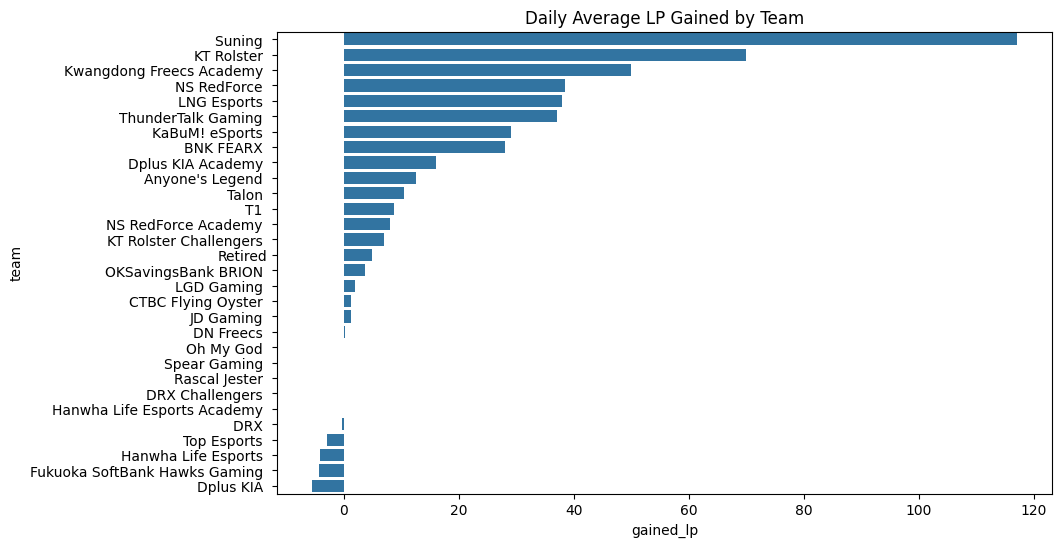

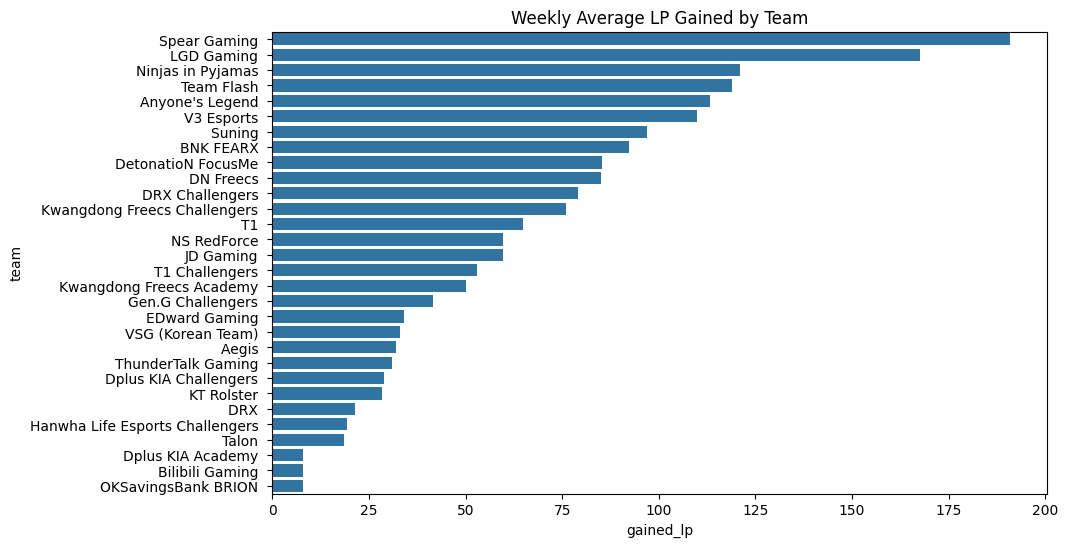

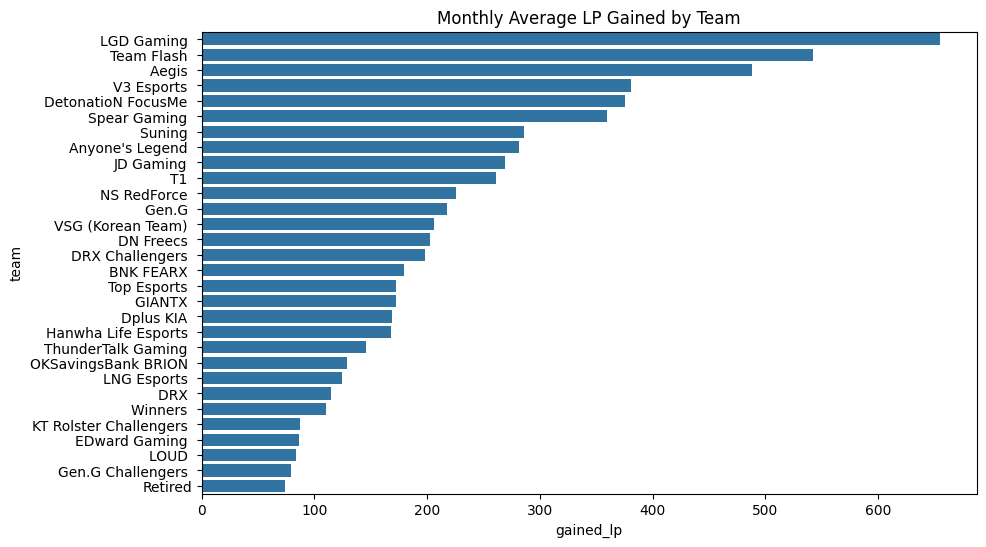

In [65]:
# Bar Plot for Top Teams: Show gained_lp by team for each timeframe.
# By average LP gained, we mean the average LP gained by each team player is x lp
for df, name in zip([daily_data, weekly_data, monthly_data], ['Daily', 'Weekly', 'Monthly']):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x='gained_lp', y='team', order=df.groupby('team')['gained_lp'].mean().sort_values(ascending=False).head(30).index, errorbar=None)
    plt.title(f"{name} Average LP Gained by Team")
    plt.show()

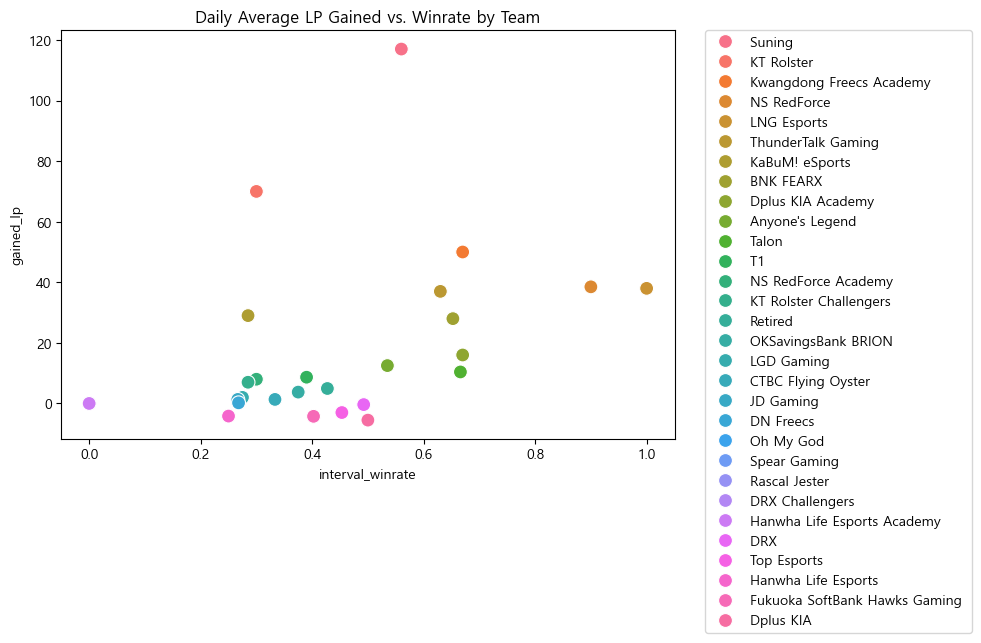

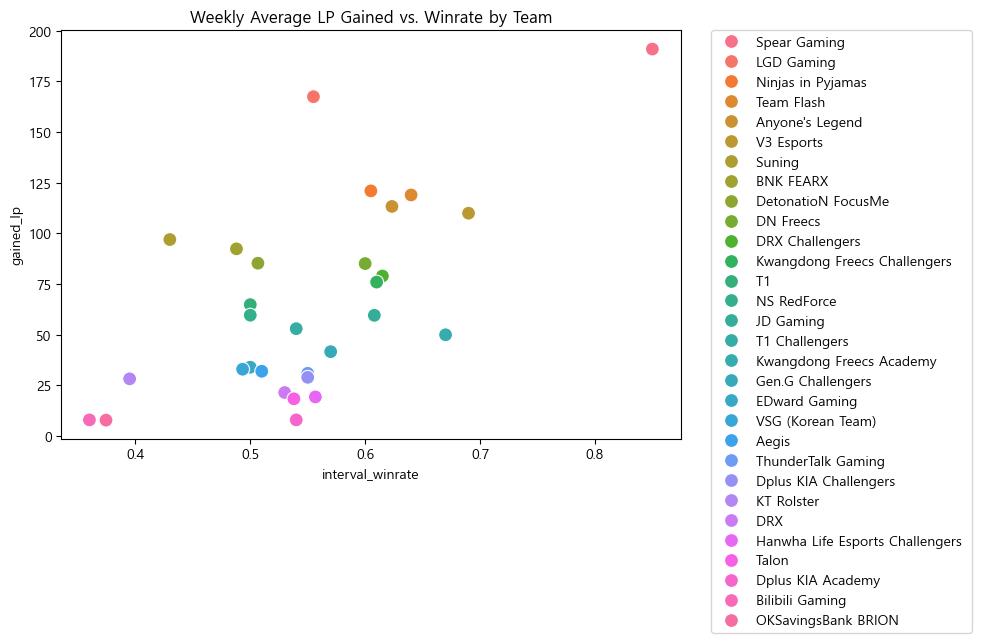

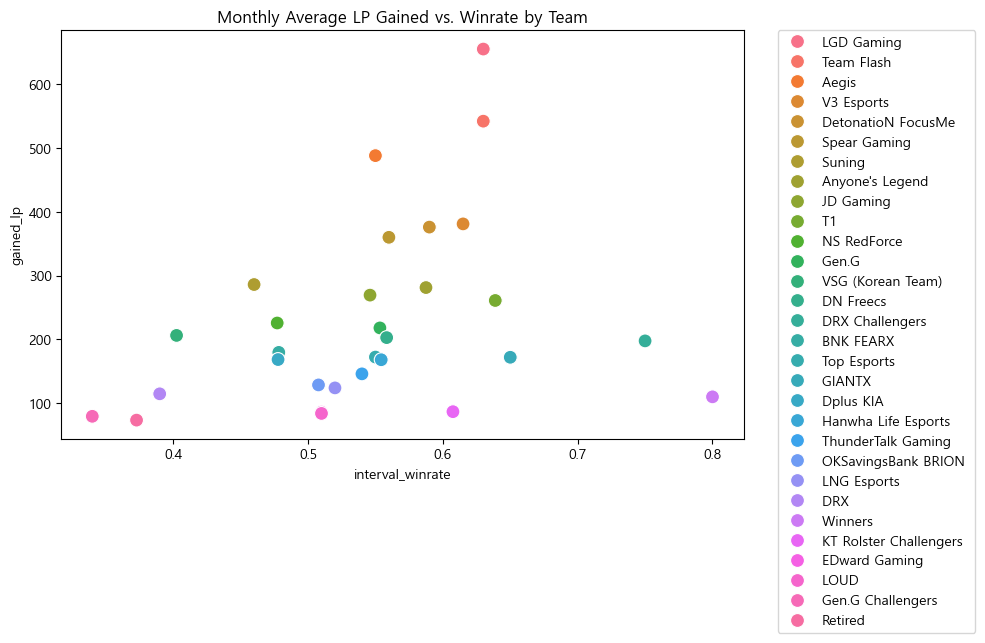

In [86]:
for df, name in zip([daily_data, weekly_data, monthly_data], ['Daily', 'Weekly', 'Monthly']):
    # Calculate team averages
    top_10_teams_avg = df.groupby('team')[['interval_winrate', 'gained_lp']].mean().sort_values(by="gained_lp", ascending=False).head(30).reset_index()
    
    plt.figure(figsize=(10, 6))
    ax = sns.scatterplot(data=top_10_teams_avg, x='interval_winrate', y='gained_lp', hue='team', s=100)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.title(f"{name} Average LP Gained vs. Winrate by Team")
    plt.tight_layout()
    plt.show()

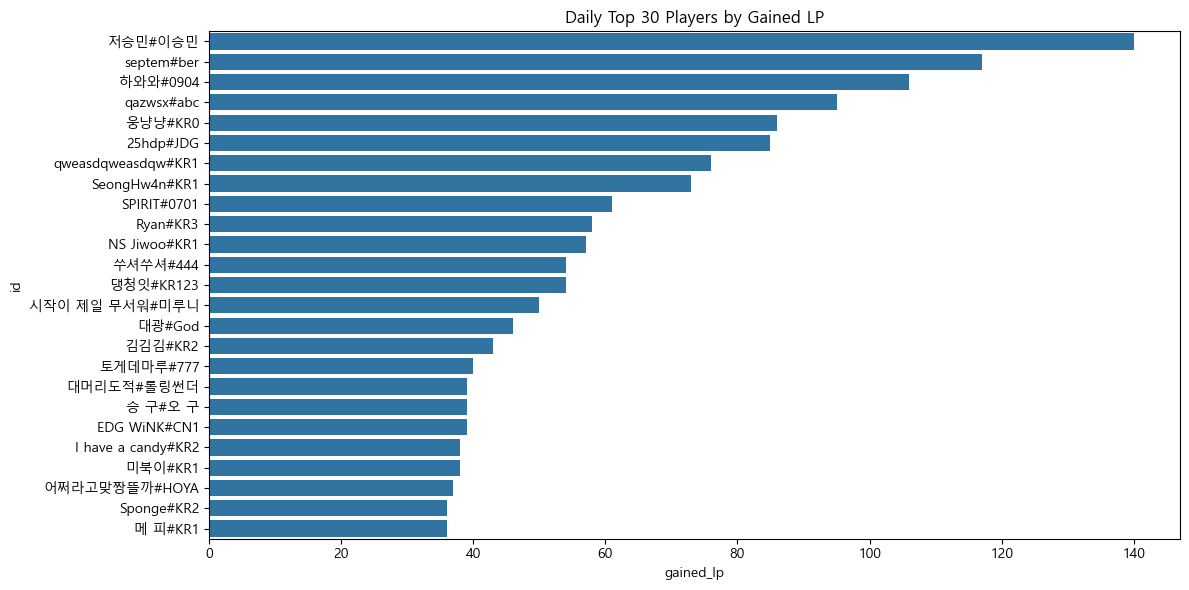

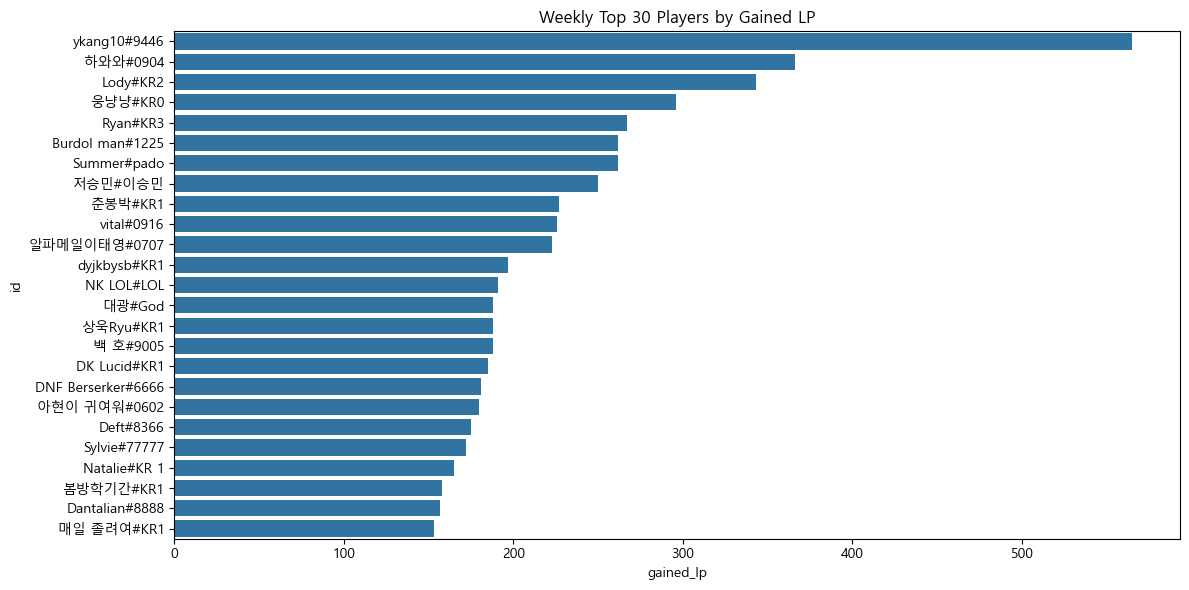

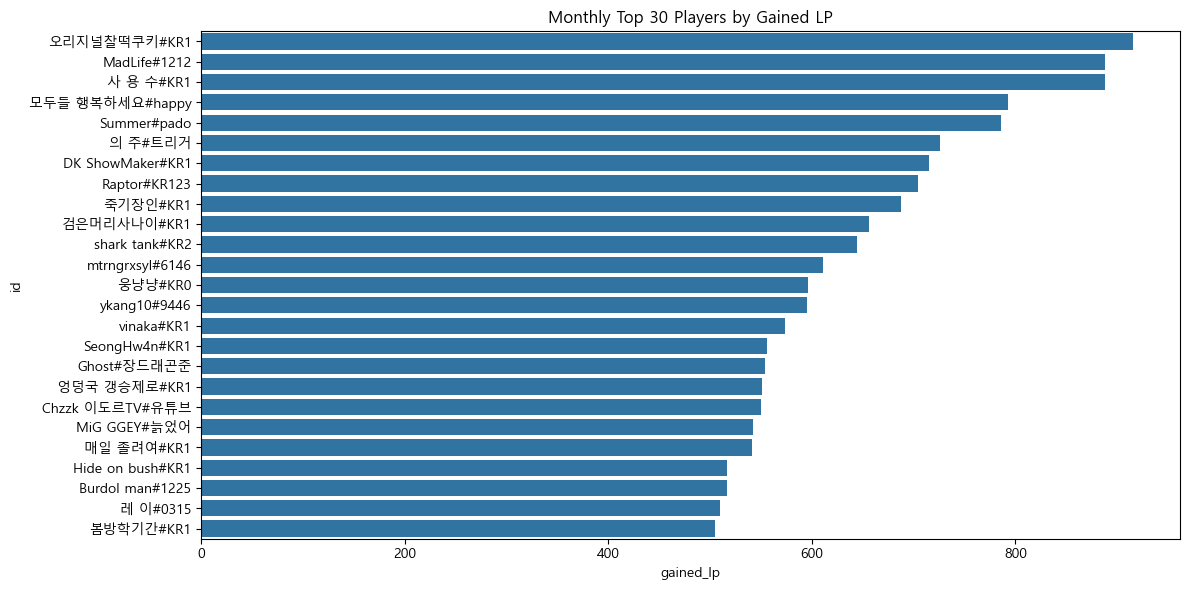

In [89]:
# Top 30 players over every timeframe:
for df, name in zip([daily_data, weekly_data, monthly_data], ['Daily', 'Weekly', 'Monthly']):
    # Get the top 30 players sorted by gained_lp
    top_players = df.sort_values('gained_lp', ascending=False).head(25)
    
    plt.rcParams['font.family'] = 'Malgun Gothic'  # Common Korean font
    plt.figure(figsize=(12, 6))
    sns.barplot(data=top_players, x='gained_lp', y='id', errorbar=None)
    plt.title(f"{name} Top 30 Players by Gained LP")
    plt.tight_layout()
    plt.show()